In [27]:
import pickle
from typing import List, Dict

import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

%matplotlib inline

In [2]:
def calculate_weight_importance(model: AutoModelForCausalLM, input_ids: torch.Tensor) -> Dict[str, torch.Tensor]:
    """
    Calculates the weight importance for a single sample.
    
    Args:
        model: The Llama model.
        input_ids: The input tensor.
    
    Returns:
        A dictionary of weight importances for each parameter.
    """
    model.zero_grad()
    output = model(input_ids)
    loss = output.logits.norm()
    loss.backward()
    
    importance = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            importance[name] = param.grad.abs().detach().cpu()
    model.zero_grad()
    
    return importance


def process_dataset(model: AutoModelForCausalLM, tokenizer: AutoTokenizer, prompts: List[str]) -> Dict[str, torch.Tensor]:
    """
    Processes a dataset and calculates average weight importances.
    
    Args:
        model: The Llama model.
        tokenizer: The tokenizer.
        prompts: List of prompts to process.
    
    Returns:
        A dictionary of average weight importances for each parameter.
    """
    total_importance = {}
    count = 0
    
    for prompt in prompts:
        input_ids = tokenizer.encode(prompt, return_tensors='pt').to(model.device)
        importance = calculate_weight_importance(model, input_ids)
        
        for name, imp in importance.items():
            if name not in total_importance:
                total_importance[name] = imp
            else:
                total_importance[name] += imp
        
        count += 1
    
    # Calculate average
    for name in total_importance:
        total_importance[name] /= count
    
    return total_importance

In [3]:
def save_results(filename: str, data: Dict[str, torch.Tensor]):
    """Saves the results to a pickle file."""
    with open(filename, 'wb') as f:
        pickle.dump(data, f)


def load_results(filename: str) -> Dict[str, torch.Tensor]:
    """Loads the results from a pickle file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)


def calculate_difference(set1: Dict[str, torch.Tensor], set2: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    """Calculates the difference between two sets of weight importances."""
    diff = {}
    for name in set1:
        diff[name] = set1[name] - set2[name]
    return diff


In [4]:
model_name = 'meta-llama/Llama-3.2-1B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map='auto',
    attn_implementation='flash_attention_2',
)

In [5]:
# Example prompts
questions = [
    "Who was the first president of the United States?",
    "What is the capital of France?",
    "When was the Declaration of Independence signed?",
]

statements = [
    "George Washington played a crucial role in the founding of the United States.",
    "The Eiffel Tower is an iconic landmark in a major European city.",
    "The American Revolution led to the creation of a significant document in 1776.",
]

In [6]:
question_importances = process_dataset(model, tokenizer, questions)
save_results('question_importances.pkl', question_importances)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [77]:
statement_importances = process_dataset(model, tokenizer, statements)
save_results('statement_importances.pkl', statement_importances)

In [79]:
differences = calculate_difference(question_importances, statement_importances)
save_results('importance_differences.pkl', differences)

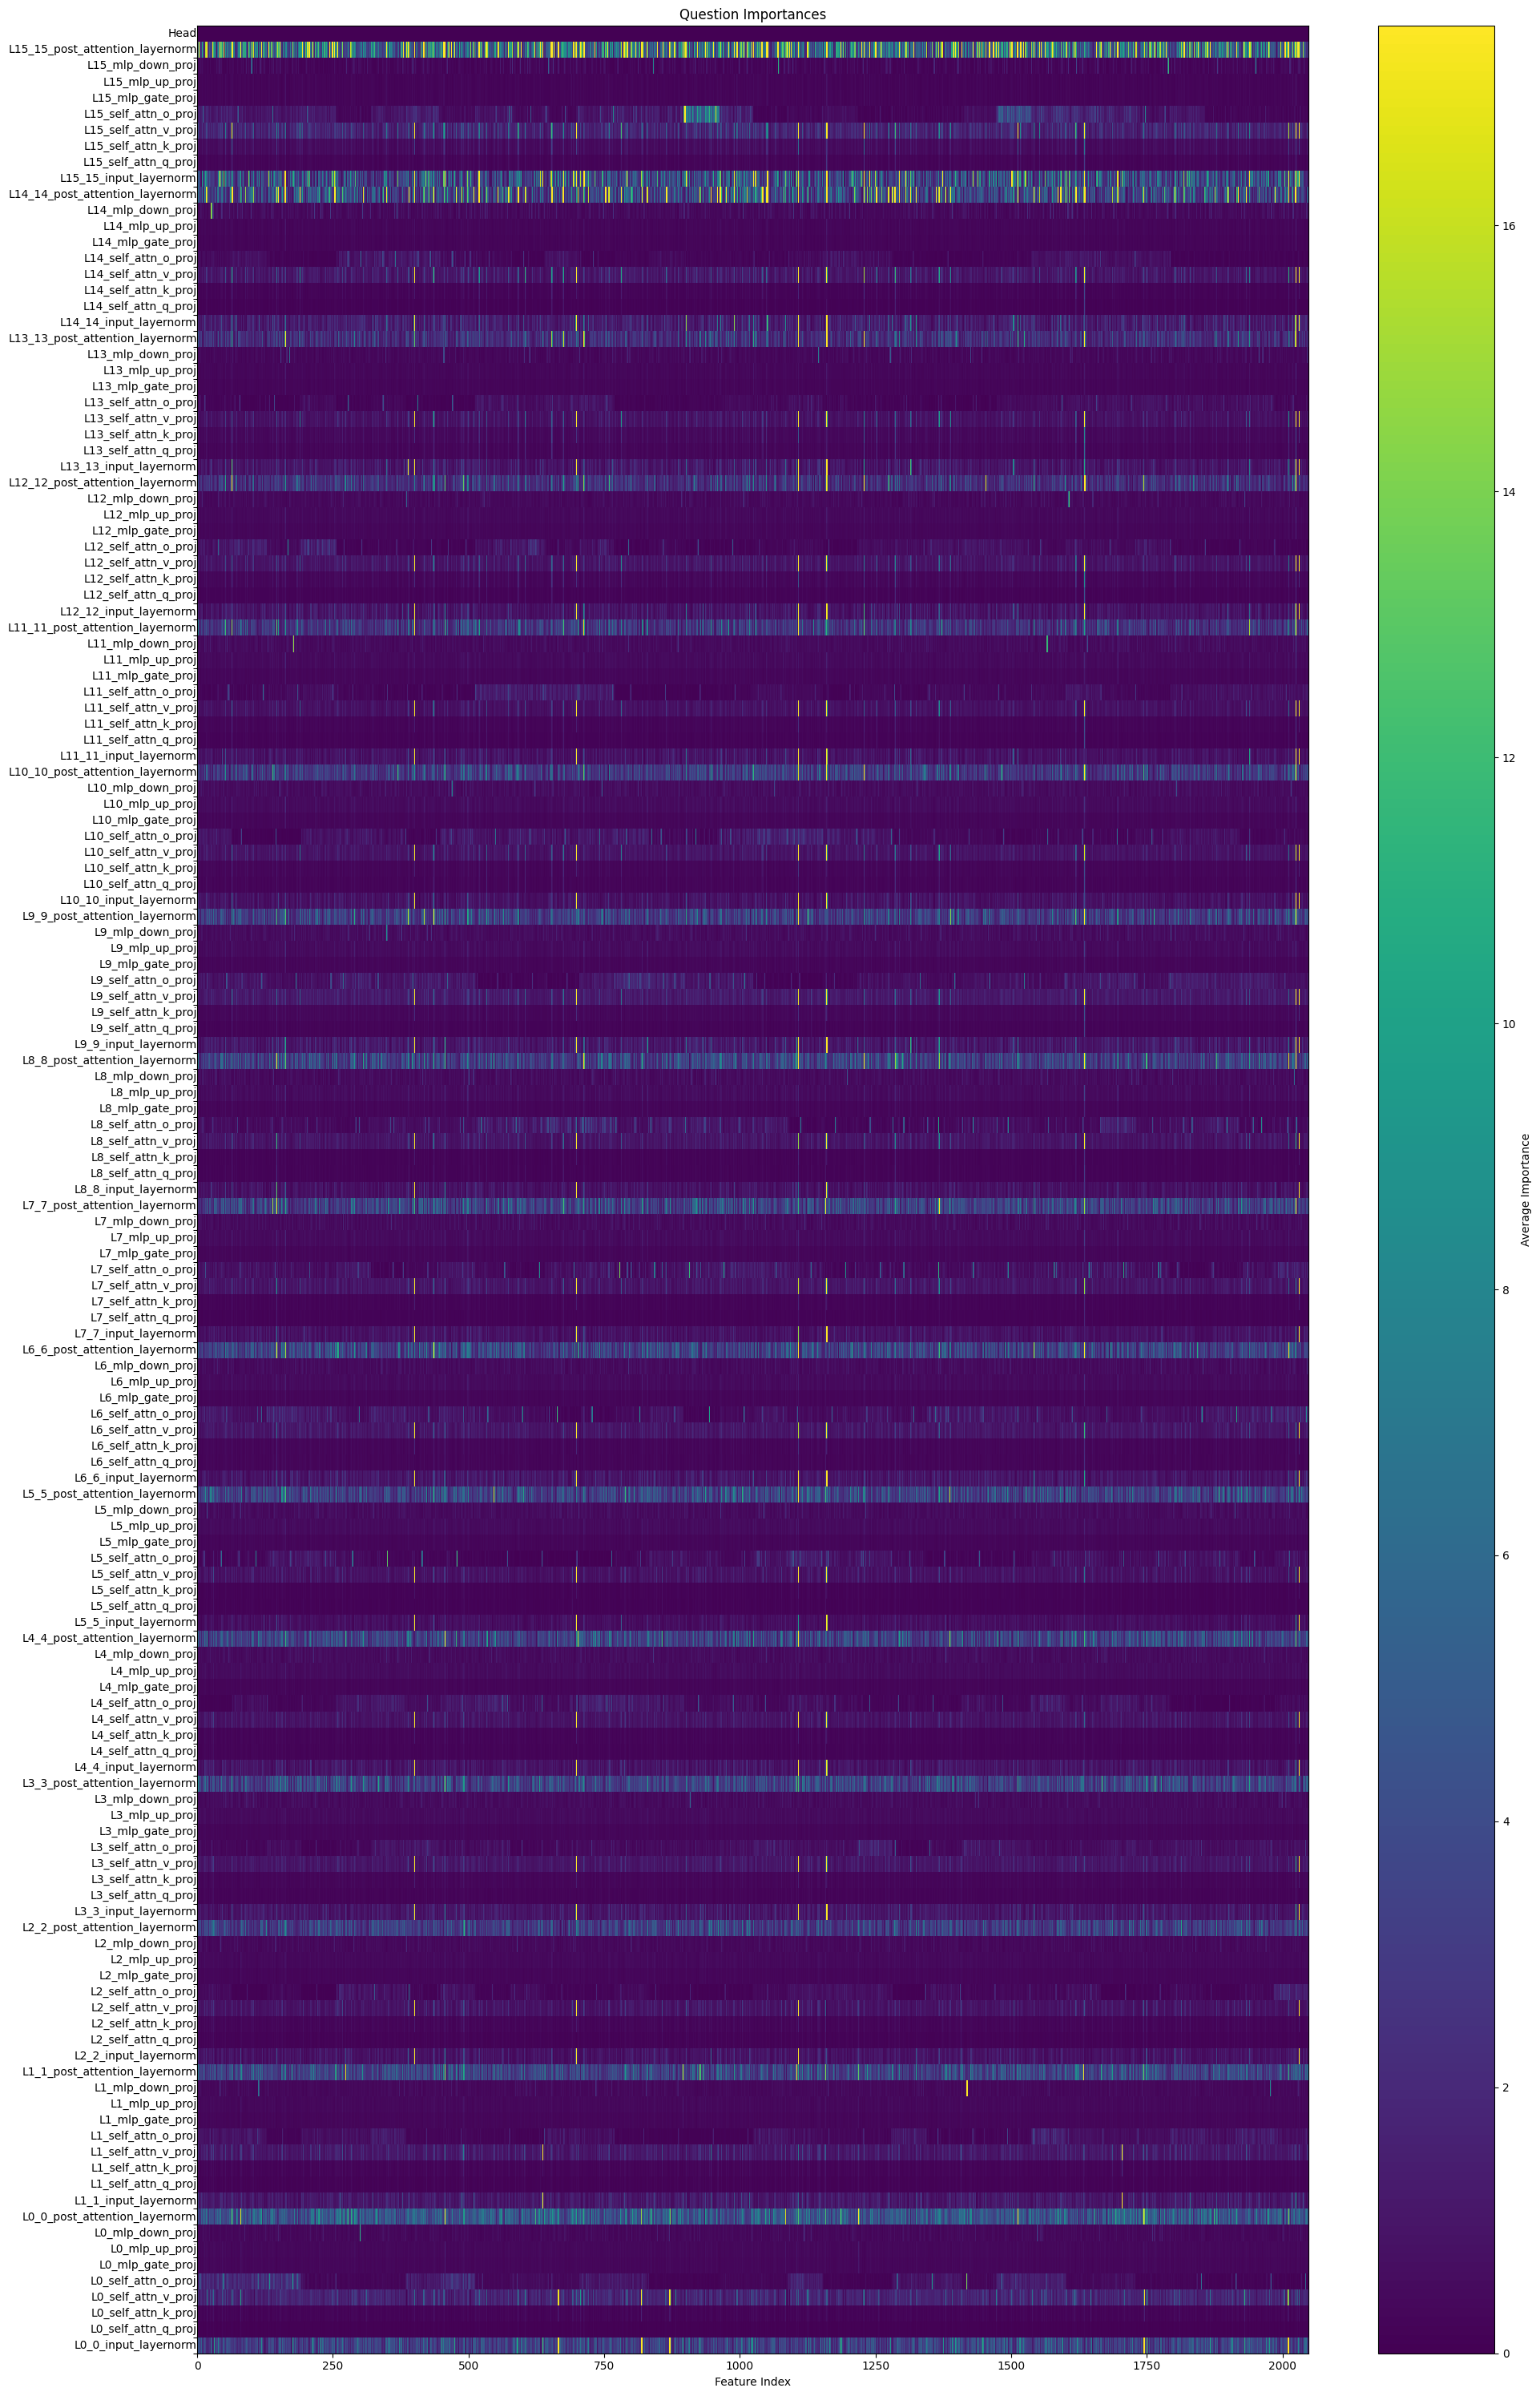

In [95]:
importances = question_importances
normalize_across_layers = True
pool_window = 1
value_range = None


# def plot_importances(importances, normalize_across_layers=False):
plt.figure(figsize=(20, 30))
plt.title("Question Importances")

layer_order = [
    'model.layers.{}.input_layernorm',
    'model.layers.{}.self_attn',
    'model.layers.{}.mlp',
    'model.layers.{}.post_attention_layernorm'
]

num_layers = max([int(k.split('.')[2]) for k in importances.keys() if k.startswith('model.layers')]) + 1
current_y = 0

feature_imps = {}

# Calculate and store all feature importances
for layer in range(num_layers):
    for layer_template in layer_order:
        layer_name = layer_template.format(layer)
        layer_weights = {k: v for k, v in importances.items() if k.startswith(layer_name)}
        
        for name, weights in layer_weights.items():
            if len(weights.shape) == 2:
                feature_imps[name] = weights.float().mean(dim=0)
            elif len(weights.shape) == 1:
                feature_imps[name] = weights.float()
                
            if pool_window is not None and pool_window > 1:
                feature_imps[name] = feature_imps[name].unfold(0, pool_window, pool_window).mean(dim=1)

# Add embed_tokens to feature_imps
weights = importances['model.embed_tokens.weight']
feature_imps['model.embed_tokens.weight'] = weights.mean(dim=0)

if pool_window is not None and pool_window > 1:
    feature_imps['model.embed_tokens.weight'] = feature_imps['model.embed_tokens.weight'].unfold(
        0, pool_window, pool_window).mean(dim=1)

if value_range is None:
    if normalize_across_layers:
        vmin = 0
        vmax = torch.quantile(torch.cat(list(feature_imps.values())), 0.998)
    else:
        vmin = vmax = None
else:
    vmin, vmax = value_range

for layer in range(num_layers):
    for layer_template in layer_order:
        layer_name = layer_template.format(layer)
        layer_weights = {k: v for k, v in importances.items() if k.startswith(layer_name)}
        
        for name in layer_weights.keys():
            feature_imp = feature_imps[name]
            plt.imshow(feature_imp.unsqueeze(0), aspect='auto', extent=[0, feature_imp.size(0), current_y, current_y+1], cmap='viridis', vmin=vmin, vmax=vmax)
            plt.text(-0.5, current_y+0.5, f'L{layer}_{name.split(".")[-3]}_{name.split(".")[-2]}', va='center', ha='right')
            current_y += 1

# Visualize embed_tokens at the end (shared with head)
feature_imp = feature_imps['model.embed_tokens.weight']
plt.imshow(feature_imp.unsqueeze(0).float(), aspect='auto', extent=[0, feature_imp.size(0), current_y, current_y+1], cmap='viridis', vmin=vmin, vmax=vmax)
plt.text(-0.5, current_y+0.5, 'Head', va='center', ha='right')
    
plt.yticks(range(current_y), [])
plt.xlabel('Feature Index')
cbar = plt.colorbar(label='Average Importance')
# cbar.ax.text(0.5, -0.1, f'vmin: {vmin:.2f}', transform=cbar.ax.transAxes, ha='center', va='top')
# cbar.ax.text(0.5, 1.1, f'vmax: {vmax:.2f}', transform=cbar.ax.transAxes, ha='center', va='bottom')
plt.tight_layout()
plt.show()

# # Call the function with the desired option
# plot_importances(importances, normalize_across_layers=True)

In [32]:
def visualize_feature_importances(importances: Dict[str, torch.Tensor], title: str):
    """
    Visualizes feature importances for the model.
    
    Args:
        importances: Dictionary of weight importances.
        title: Title for the plot.
    """
    plt.figure(figsize=(20, 30))
    plt.title(title)

    layer_order = [
        'model.layers.{}.input_layernorm',
        'model.layers.{}.self_attn',
        'model.layers.{}.mlp',
        'model.layers.{}.post_attention_layernorm'
    ]

    num_layers = max([int(k.split('.')[2]) for k in importances.keys() if k.startswith('model.layers')]) + 1
    current_y = 0

    # Visualize embed_tokens at the beginning
    weights = importances['model.embed_tokens.weight']
    feature_imp = weights.mean(dim=1)
    plt.imshow(feature_imp.unsqueeze(0).float(), aspect='auto', extent=[0, feature_imp.size(0), current_y, current_y+1])
    plt.text(-0.5, current_y+0.5, 'embed', va='center', ha='right')
    current_y += 1

    for layer in range(num_layers):
        for layer_template in layer_order:
            layer_name = layer_template.format(layer)
            layer_weights = [v for k, v in importances.items() if k.startswith(layer_name)]
            
            for weights in layer_weights:
                feature_imp = weights.mean(dim=0)
                plt.imshow(feature_imp.unsqueeze(0).float(), aspect='auto', extent=[0, feature_imp.size(0), current_y, current_y+1])
                plt.text(-0.5, current_y+0.5, f'L{layer}_{layer_name.split(".")[-1]}', va='center', ha='right')
                current_y += 1

    # Visualize embed_tokens at the end (shared with head)
    weights = importances['model.embed_tokens.weight']
    feature_imp = weights.mean(dim=0)
    plt.imshow(feature_imp.unsqueeze(0).float(), aspect='auto', extent=[0, feature_imp.size(0), current_y, current_y+1])
    plt.text(-0.5, current_y+0.5, 'head', va='center', ha='right')

    plt.colorbar(label='Average Importance')
    plt.tight_layout()
    # plt.savefig(f'{title.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    # plt.close()

In [ ]:
visualize_feature_importances(question_importances, "Question Importances")

In [8]:
model.zero_grad()

In [12]:
model.lm_head

Linear(in_features=2048, out_features=128256, bias=False)

In [11]:
[x for x in question_importances.keys() if 'lm_head' in x]

[]

In [16]:
[x for x in model.named_parameters() if 'head' in x[0].lower()]

[]

In [26]:
(model.model.embed_tokens.weight.data == model.lm_head.weight.data).all()

tensor(True, device='cuda:0')

In [24]:
model.lm_head.weight.data.shape

torch.Size([128256, 2048])

In [10]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm